In [1]:
# Obtendo a lista de todos os filmes
import httpx
import pandas as pd
from bs4 import BeautifulSoup

FILMES_NOMINADOS_XPATH = "#mw-content-text > div table"
# Obtendo a lista de todos os filmes
page = httpx.get("https://en.wikipedia.org/wiki/List_of_Academy_Award%E2%80%93nominated_films")

wikipedia_soup = BeautifulSoup(page.text, 'html.parser')
nominados_table_src = wikipedia_soup.select_one(FILMES_NOMINADOS_XPATH)

nominados_df = pd.read_html(str(nominados_table_src))[0]

nominados_df.head()

/tmp/ipykernel_53874/3432725883.py:13: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  nominados_df = pd.read_html(str(nominados_table_src))[0]


,Film,Released,Ceremony,Awards,Nominations
0,Wings,1927,1st,2,2
1,7th Heaven,1927,1st,3,5
2,Sunrise: A Song of Two Humans,1927,1st,3,4
3,The Last Command,1928,1st,1,2
4,Street Angel,1928,1st / 2nd,1,3


In [2]:
from datetime import  date
# Associando os fimes dos ultimos 10 anos com o ID do IMDB via OMDB
nominados_df["Released"] = pd.to_numeric(nominados_df["Released"])

nominados_10_anos_df = nominados_df.query(f"Released >= {date.today().year - 10} and Released <= {date.today().year}", )

nominados_10_anos_df.head()

,Film,Released,Ceremony,Awards,Nominations
4641,Spotlight,2015,88th,2,6
4642,Mad Max: Fury Road,2015,88th,6,10
4643,The Revenant,2015,88th,3,12
4644,Bridge of Spies,2015,88th,1,6
4645,The Big Short,2015,88th,1,5


In [ ]:
import httpx
import os
from dotenv import  load_dotenv
filmes_sem_dados_financeiros = []
load_dotenv()


# Percorrer cada coluna e adicionar informacoes

for i, row in nominados_10_anos_df.iterrows():
    request = httpx.get("http://www.omdbapi.com", params={
        "apikey": os.getenv("OMDB_API_KEY"),
        "t": row["Film"],
        "y": row["Released"]
    })
    request.raise_for_status()
    data =request.json()
    coast = data.get("BoxOffice", "N/A")
    coast = coast.replace("$", "").replace(",", "")
    if coast == 'N/A':
        coast = None
        filmes_sem_dados_financeiros.append(row["Film"])
    else:
        coast = float(coast)
    nominados_10_anos_df.at[i, 'Cost'] = coast




/tmp/ipykernel_53874/2974943744.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nominados_10_anos_df.at[i, 'Cost'] = coast


In [4]:
import numpy as np


nominados_10_anos_df = nominados_10_anos_df[~nominados_10_anos_df["Film"].isin(filmes_sem_dados_financeiros)]
nominados_10_anos_df["Awards"] = np.int64(nominados_10_anos_df["Awards"])


In [5]:
# O custo do "Melhor filme por ano"

df_max_awards = nominados_10_anos_df.loc[nominados_10_anos_df.groupby('Released')['Awards'].idxmax()]
# O custo de "Mais nominado por ano"
df_max_nomination = nominados_10_anos_df.loc[nominados_10_anos_df.groupby('Released')['Nominations'].idxmax()]



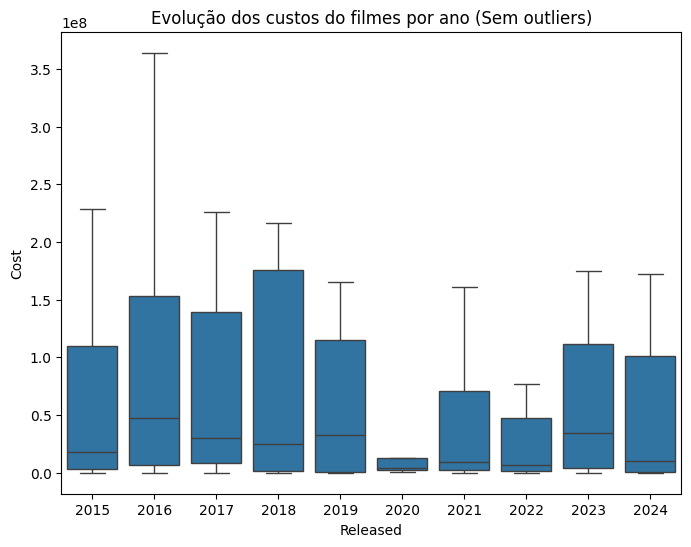

In [6]:
# Distribuição de custo de filme por ano

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.title("Evolução dos custos do filmes por ano (Sem outliers)")
sns.set_theme(style="ticks", palette="pastel")

sns.boxplot(x="Released", y="Cost",data=nominados_10_anos_df, showfliers=False)
plt.show()


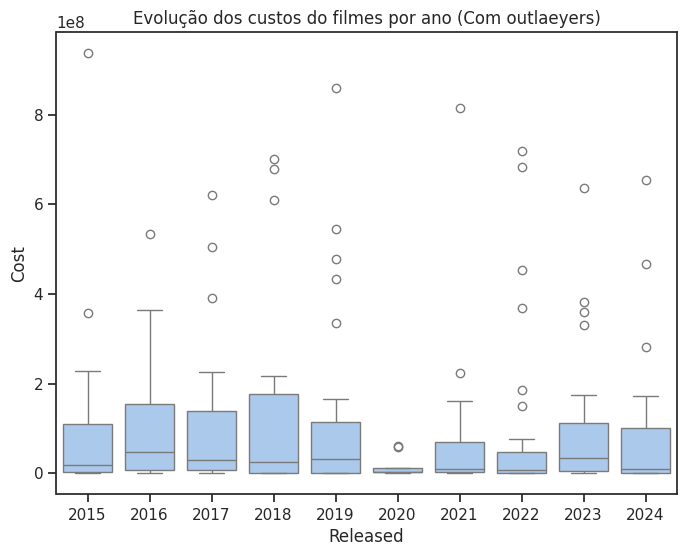

In [7]:
# Distribuição de custo de filme por ano

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.title("Evolução dos custos do filmes por ano (Com outlaeyers)")
sns.set_theme(style="ticks", palette="pastel")

sns.boxplot(x="Released", y="Cost",data=nominados_10_anos_df, showfliers=True)

plt.show()

<Axes: title={'center': 'Evolução do custos dos melhores filmes'}, xlabel='Released', ylabel='Cost'>

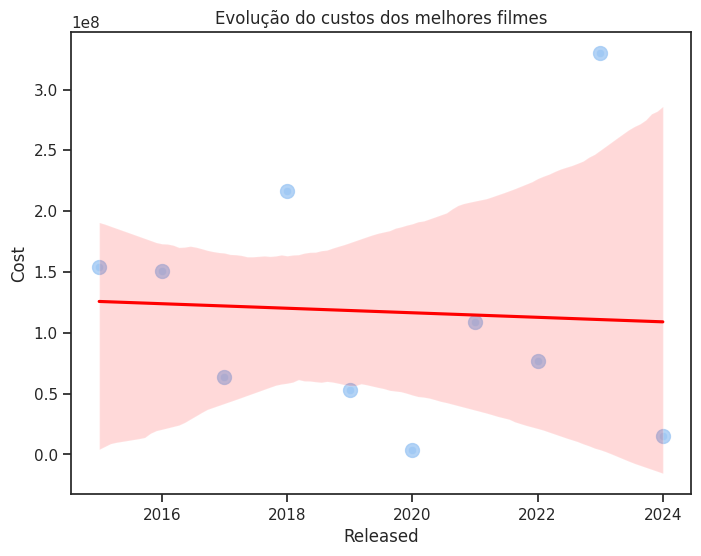

In [8]:
# Plotando o custo dos melhores filmes
import seaborn as sns

plt.figure(figsize=(8, 6))

plt.title("Evolução do custos dos melhores filmes")
sns.set_theme(style="ticks")
sns.scatterplot(data=df_max_awards, x="Released", y="Cost")
sns.regplot(data=df_max_awards, x='Released', y='Cost', scatter_kws={'s': 100}, line_kws={'color': 'red'})



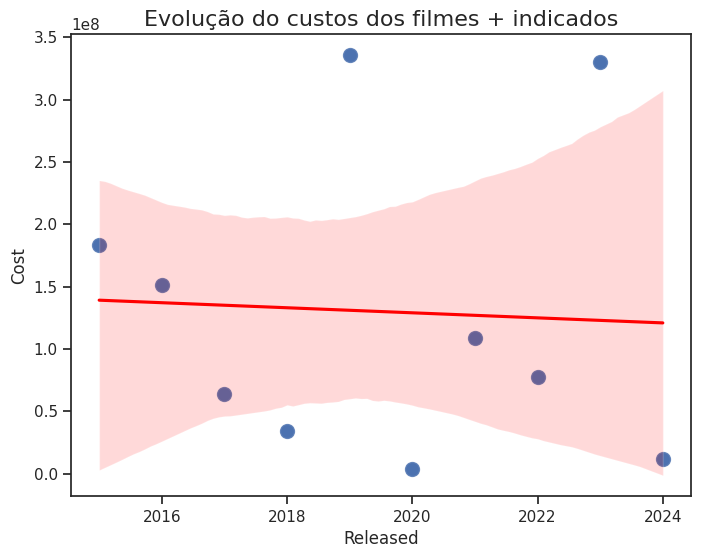

In [9]:
# Plotando o custo dos melhores filmes
plt.figure(figsize=(8, 6))
plt.title('Evolução do custos dos filmes + indicados', fontsize=16)

sns.scatterplot(data=df_max_nomination, x="Released", y="Cost", s=100)
sns.regplot(data=df_max_nomination, x='Released', y='Cost', scatter_kws={'s': 100}, line_kws={'color': 'red'})

plt.show()

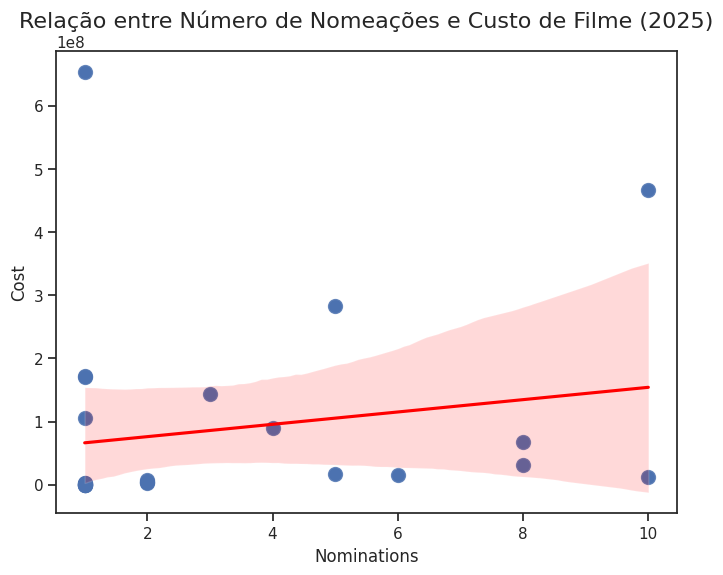

In [10]:
# Distribuição de custo x indicação 2025
import matplotlib.pyplot as plt

nominados_2025_df = nominados_10_anos_df.query(f"Released == {date.today().year -1}")
plt.figure(figsize=(8, 6))
sns.scatterplot(data=nominados_2025_df, x='Nominations', y='Cost', s=100)
plt.title('Relação entre Número de Nomeações e Custo de Filme (2025)', fontsize=16)
plt.xlabel('Número de Nomeações', fontsize=12)
plt.ylabel('Custo do Filme ($)', fontsize=12)

sns.regplot(data=nominados_2025_df, x='Nominations', y='Cost', scatter_kws={'s': 100}, line_kws={'color': 'red'})

# Exibindo o gráfico
plt.show()

/tmp/ipykernel_53874/3019499511.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nominados_2025_df["Awards"] = np.int64(nominados_2025_df["Awards"])


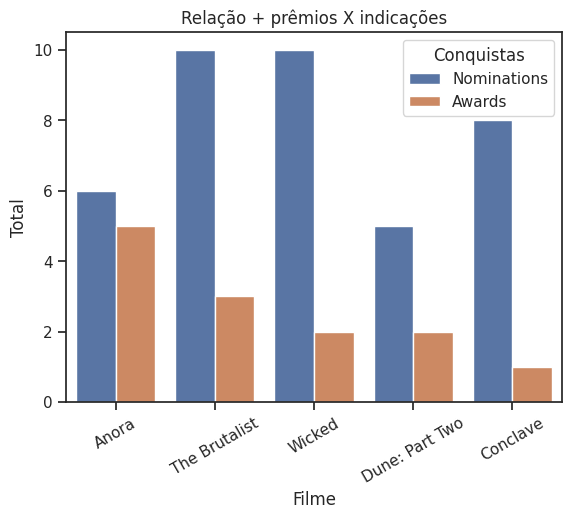

In [11]:
# Distribuição de Ganhadores X indicados
import matplotlib.pyplot as plt
import numpy as np

nominados_2025_df = nominados_10_anos_df.query(f"Released == {date.today().year -1}")
nominados_2025_df["Awards"] = np.int64(nominados_2025_df["Awards"])
nominados_2025_top_df = nominados_2025_df.nlargest(5, "Awards")



dados_long = pd.melt(nominados_2025_top_df, id_vars=['Film'], value_vars=['Nominations', 'Awards'],
                     var_name='Conquistas', value_name='Total')
plt.figure()

sns.set_color_codes("pastel")
sns.barplot(data=dados_long, x='Film', y='Total', dodge=True, hue="Conquistas")

plt.xticks(rotation=30)
plt.xlabel("Filme")
plt.title("Relação + prêmios X indicações")

# Exibindo o gráfico
plt.show()

/tmp/ipykernel_53874/2731483331.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nominados_2025_df["Awards"] = np.int64(nominados_2025_df["Awards"])


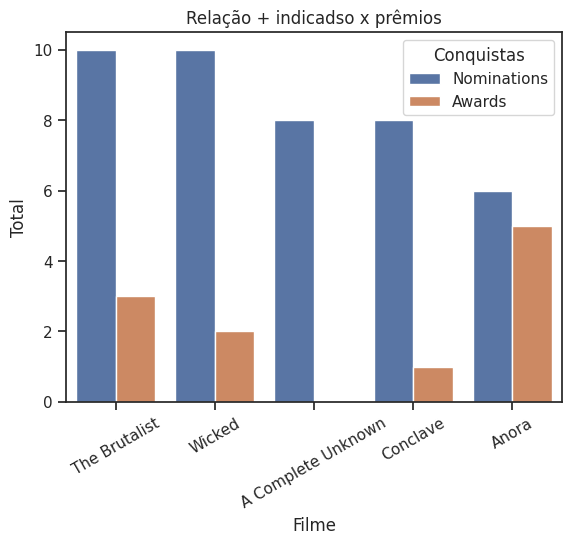

In [12]:
# Distribuição de Ganhadores X indicados
import matplotlib.pyplot as plt
import numpy as np

nominados_2025_df = nominados_10_anos_df.query(f"Released == {date.today().year -1}")
nominados_2025_df["Awards"] = np.int64(nominados_2025_df["Awards"])
nominados_2025_top_df = nominados_2025_df.nlargest(5, "Nominations")



dados_long = pd.melt(nominados_2025_top_df, id_vars=['Film'], value_vars=['Nominations', 'Awards'],
                     var_name='Conquistas', value_name='Total')
plt.figure()

sns.set_color_codes("pastel")
sns.barplot(data=dados_long, x='Film', y='Total', dodge=True, hue="Conquistas")

plt.xticks(rotation=30)
plt.xlabel("Filme")
plt.title("Relação + indicadso x prêmios")

# Exibindo o gráfico
plt.show()

In [13]:
# Filmes sem custo encontrados
sem_custo = pd.DataFrame(filmes_sem_dados_financeiros)
sem_custo

,0
0,A Girl in the River: The Price of Forgiveness
1,Stutterer
2,Ave Maria
3,Body Team 12
4,"Chau, Beyond the Lines"
...,...
228,The Only Girl in the Orchestra
229,The Six Triple Eight
230,Wallace & Gromit: Vengeance Most Fowl
231,Wander to Wonder


# Montando dataset para associar as categorias indicadas e premiadas dos ultimos anos:


Essa parte vai ser mais complicada, mas decidi partir da premissa de que eu devo gerar um dataset do zero dessa vez, vi datasets como o do kaggle que me deram uma ótima idéia.

1. Buscar nas páginas da wikipedia de cada premiação
2. Criar um dataset com a informação dos indicados e ganhadores do oscar repetindo as linahs quando necessário
3. Usar a API do OMDB para associar id do IMDB e custo



In [23]:
# buscar no wikipedia todos as cerimônias do oscar
import httpx
from bs4 import  BeautifulSoup
import pandas as pd
from io import  StringIO
request = httpx.get("https://en.wikipedia.org/wiki/List_of_Academy_Awards_ceremonies")

request.raise_for_status()

cerimony_table_bs4 = BeautifulSoup(request.text, "html.parser")

cerimony_table_src = cerimony_table_bs4.select("#mw-content-text > div.mw-content-ltr.mw-parser-output table")

cerimony_list_df = pd.read_html(StringIO(str(cerimony_table_src[1])))[0]

cerimony_list_df.head()

cerimony_list_df["url"] = cerimony_list_df["#"].apply(lambda x: f"https://en.wikipedia.org/wiki/{x}_Academy_Awards")

cerimony_list_df.to_csv("cerimony_list.csv", sep=";")

In [ ]:
# Implementando um dataframe gigantesco onde
import httpx
from bs4 import BeautifulSoup
from lxml import etree

ceremonies_df = pd.DataFrame(columns=["#", "Date", "Categories"])
nominated_all_df = pd.DataFrame(
    columns=["#", "Date", "Category", "Movie", "Winner", "Wikipedia_URL"]
)
movies_in_ceremony_list = []
# Problemas com a formatação da tabela da 18h edição do oscar
# TODO: implrmrntação separada para conseguir usar outros formatos de tabela
for i, row in cerimony_list_df[-40:].iterrows():
    categories_in_ceremony_list = []
    try:
        request = httpx.get(row["url"])
        request.raise_for_status()

        tree = etree.HTML(request.text)

        categories_in_ceremony_table = tree.xpath(
            "//*[@id='Winners_and_nominees']/../following-sibling::table[1]"
        )[0]
        for tr in categories_in_ceremony_table.xpath(".//tbody/tr/td"):
            winner = tr.xpath(".//ul/li/b/i/a")
            if not winner:
                winner = tr.xpath(".//ul/li/i/b/a")
            if not winner:
                continue
            category_name = tr.xpath(".//div/b/a")
            if not category_name:
                category_name = tr.xpath(".//div/b")
            category_name = category_name[-1].text.strip()
            winner = winner[0].text.strip()
            movies_in_ceremony_list.append(
                {
                    "#": row["#"],
                    "Date": row["Date"],
                    "Category": category_name,
                    "Winner": True,
                    "Movie": winner,
                    "Wikipedia_URL": row["url"],
                }
            )
            others = list(map(lambda x: x.text.strip(), tr.xpath(".//ul/li/ul/li/i/a")))
            for other in others:
                movies_in_ceremony_list.append(
                    {
                        "#": row["#"],
                        "Date": row["Date"],
                        "Category": category_name,
                        "Winner": False,
                        "Movie": other,
                        "Wikipedia_URL": row["url"],
                    }
                )

        # categories_in_ceremony_list = list(set(map(lambda x: x.text, categories_in_ceremony_src)))
    except httpx.HTTPError:
        print(f"Not found ceremony page for {row['#']}")
    finally:
        cerimony_list_df.at[i, "Categories"] = ",".join(categories_in_ceremony_list)
        nominated_all_df = pd.concat(
            [nominated_all_df, pd.DataFrame(movies_in_ceremony_list)], ignore_index=True
        )

cerimony_list_df.to_csv("ceremony_list.csv", sep=";")
nominated_all_df.to_csv("nominated_all.csv", sep=";")
